# Estimating COVID-19's $R_t$ in Real-Time for India
> Estimating R0 for States as a Time Series

- toc: true 
- badges: false
- comments: true
- authors: Meghana Bhange and Nirant Kasliwal
- image: images/IndiaRT.png
<!-- - metadata_key1: metadata_value1 -->
<!-- - metadata_key2: metadata_value2 -->

# Estimating COVID-19's $R_t$ in Real-Time

#### Based on [Kevin Systrom's work](https://github.com/k-sys/covid-19) which in turns builds on  [Bettencourt & Ribeiro 2008](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0002185)


In any epidemic, $R_t$ is the measure known as the effective reproduction number. It's the number of people who become infected per infectious person at time $t$. The most well-known version of this number is the basic reproduction number: $R_0$ when $t=0$. However, $R_0$ is a single measure that does not adapt with changes in behavior and restrictions.

As a pandemic evolves, increasing restrictions (or potential releasing of restrictions) change $R_t$. Knowing the current $R_t$ is essential. When $R>1$, the pandemic will spread through the entire population. If $R_t<1$, the pandemic will grow to some fixed number less than the population. The lower $R_t$, the more manageable the situation. The value of $R_t$ helps us (1) understand how effective our measures have been controlling an outbreak and (2) gives us vital information about whether we should increase or reduce restrictions based on our competing goals of economic prosperity and human safety. [Well-respected epidemiologists argue](https://www.nytimes.com/2020/04/06/opinion/coronavirus-end-social-distancing.html) that tracking $R_t$ is the only way to manage through this crisis.

So far, there has been no similar work in India. This compliments the work Prof. Shamika Ravi where she tracks [Compounded Daily Growth](https://twitter.com/ShamikaRavi/status/1251346495799844865) to understand the pandemic response. 

**More importantly**, it is not useful to understand $R_t$ at a national level. 

Instead, to manage this crisis effectively, we need a local (state, district and/or city) level granularity of $R_t$.

<!-- Yet, today, to my knowledge there is no real-time tracking of $R_t$ in United States. In fact, the only real-time measure I've seen has been for [Hong Kong](https://covid19.sph.hku.hk/dashboard). 

What follows is a solution to this problem at the US State level. It's a modified version of a solution created by [Bettencourt & Ribeiro 2008](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0002185) to estimate real-time $R_t$ using a Bayesian approach. While I have stayed true to most of their process, my solution differs in an important way that I will call out clearly.

If you have questions, comments, or improvments feel free to get in touch: [hello@systrom.com](mailto:hello@systrom.com). And if it's not entirely clear, I'm not an epidemiologist. At the same time, data is data, and statistics are statistics and this is based on work by well-known epidemiologists so calibrate accordingly. In the meantime, I hope you can learn something new as I did by reading through this example. Feel free to take this work and apply it elsewhere – internationally or to counties in the United States. -->

In [1]:
# hide
import json
import warnings

import numpy as np
import pandas as pd
from IPython.display import clear_output
from matplotlib import dates as mdates
from matplotlib import pyplot as plt
from matplotlib import ticker
from matplotlib.colors import ListedColormap
from matplotlib.dates import date2num, num2date
from matplotlib.patches import Patch
from scipy import stats as sps
from scipy.interpolate import interp1d


warnings.filterwarnings("ignore")
%config InlineBackend.figure_format = 'retina'

In [2]:
FILTERED_REGIONS = ["India", "Puducherry", "Andaman and Nicobar Islands", "Lakshadweep", "Ladakh"]

In [3]:
# hide_input
today = pd.to_datetime(pd.to_datetime("today").date())
print(f"Last updated on {today.date()}")

Last updated on 2020-06-06


In [4]:
# hide
# Column vector of k
k = np.arange(0, 70)[:, None]

# Different values of Lambda
lambdas = [10, 20, 30, 40]

# Evaluated the Probability Mass Function (remember: poisson is discrete)
y = sps.poisson.pmf(k, lambdas)

# Show the resulting shape
print(y.shape)

(70, 4)


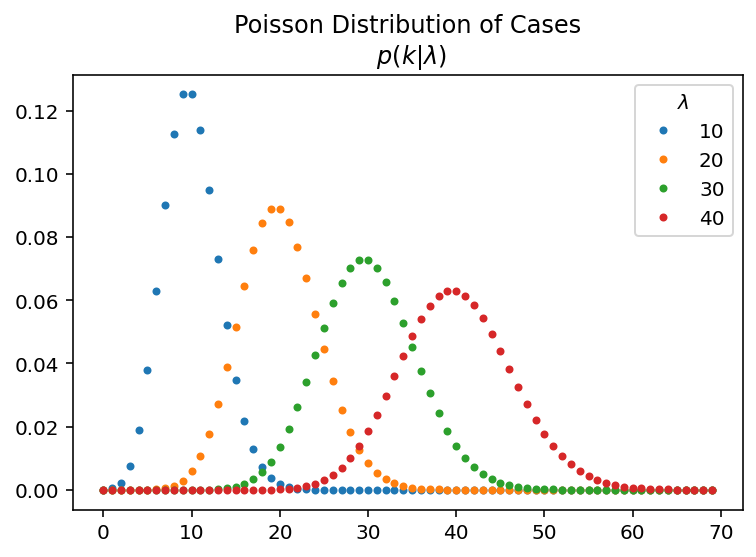

In [5]:
# hide
fig, ax = plt.subplots()

ax.set(title="Poisson Distribution of Cases\n $p(k|\lambda)$")

plt.plot(k, y, marker="o", markersize=3, lw=0)

plt.legend(title="$\lambda$", labels=lambdas)

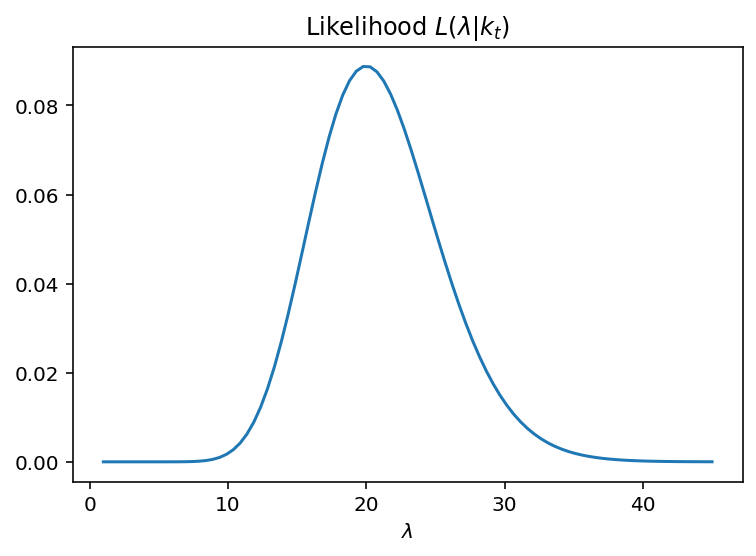

In [6]:
# hide
k = 20

lam = np.linspace(1, 45, 90)

likelihood = pd.Series(
    data=sps.poisson.pmf(k, lam), index=pd.Index(lam, name="$\lambda$"), name="lambda"
)

likelihood.plot(title=r"Likelihood $L\left(\lambda|k_t\right)$")

Text(0.5, 0, '$R_t$')

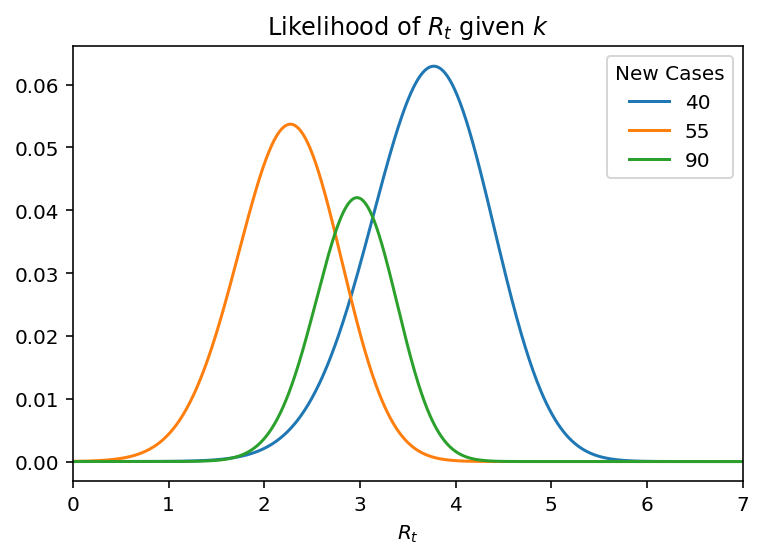

In [7]:
# hide
k = np.array([20, 40, 55, 90])

# We create an array for every possible value of Rt
R_T_MAX = 12
r_t_range = np.linspace(0, R_T_MAX, R_T_MAX * 100 + 1)

# Gamma is 1/serial interval
# https://wwwnc.cdc.gov/eid/article/26/6/20-0357_article
GAMMA = 1 / 4

# Map Rt into lambda so we can substitute it into the equation below
# Note that we have N-1 lambdas because on the first day of an outbreak
# you do not know what to expect.
lam = k[:-1] * np.exp(GAMMA * (r_t_range[:, None] - 1))

# Evaluate the likelihood on each day and normalize sum of each day to 1.0
likelihood_r_t = sps.poisson.pmf(k[1:], lam)
likelihood_r_t / np.sum(likelihood_r_t, axis=0)

# Plot it
ax = pd.DataFrame(data=likelihood_r_t, index=r_t_range).plot(
    title="Likelihood of $R_t$ given $k$", xlim=(0, 7)
)

ax.legend(labels=k[1:], title="New Cases")
ax.set_xlabel("$R_t$")

Text(0.5, 0, '$R_t$')

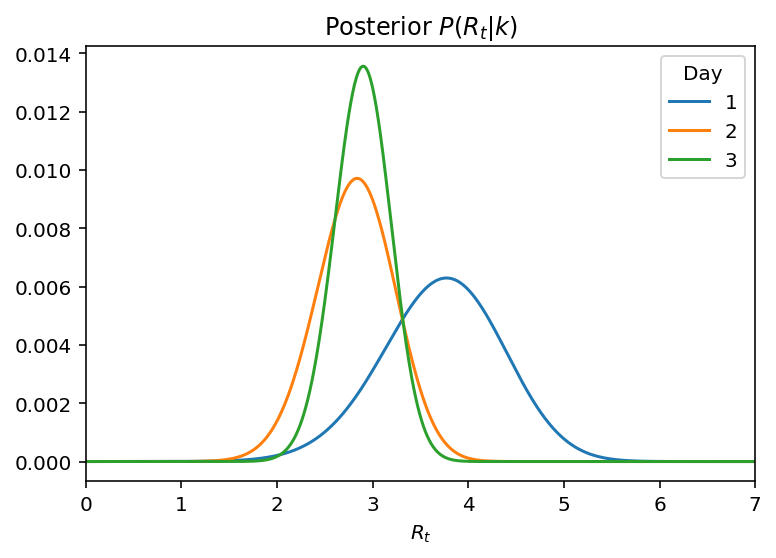

In [8]:
# hide
posteriors = likelihood_r_t.cumprod(axis=1)
posteriors = posteriors / np.sum(posteriors, axis=0)

columns = pd.Index(range(1, posteriors.shape[1] + 1), name="Day")
posteriors = pd.DataFrame(data=posteriors, index=r_t_range, columns=columns)

ax = posteriors.plot(title="Posterior $P(R_t|k)$", xlim=(0, 7))
ax.legend(title="Day")
ax.set_xlabel("$R_t$")

In [9]:
# hide
most_likely_values = posteriors.idxmax(axis=0)

In [10]:
# hide
def highest_density_interval(pmf, p=0.95):

    # If we pass a DataFrame, just call this recursively on the columns
    if isinstance(pmf, pd.DataFrame):
        return pd.DataFrame(
            [highest_density_interval(pmf[col]) for col in pmf], index=pmf.columns
        )

    cumsum = np.cumsum(pmf.values)
    best = None
    for i, value in enumerate(cumsum):
        for j, high_value in enumerate(cumsum[i + 1 :]):
            if (high_value - value > p) and (not best or j < best[1] - best[0]):
                best = (i, i + j + 1)
                break

    low = pmf.index[best[0]]
    high = pmf.index[best[1]]
    return pd.Series([low, high], index=["Low", "High"])


hdi = highest_density_interval(posteriors, p=0.95)

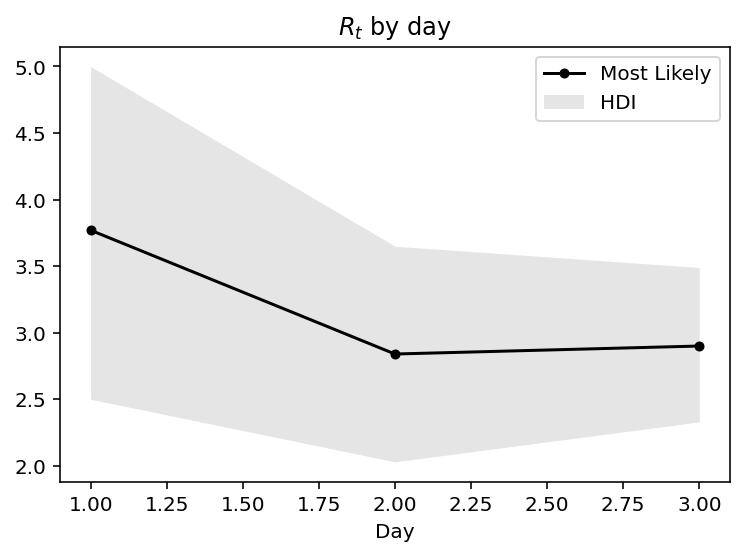

In [11]:
# hide
ax = most_likely_values.plot(
    marker="o", label="Most Likely", title=f"$R_t$ by day", c="k", markersize=4
)

ax.fill_between(
    hdi.index, hdi["Low"], hdi["High"], color="k", alpha=0.1, lw=0, label="HDI"
)

ax.legend()

# Real-World Application to Indian Data

### Setup

Load Indian state case data from the covid19india.org crowdsource database

In [12]:
# hide
# url = 'https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv'
# states = pd.read_csv(url,
#                      usecols=[0,1,3],
#                      index_col=['state', 'date'],
#                      parse_dates=['date'],
#                      squeeze=True).sort_index()

In [13]:
#hide
# for key in set(state):
#     if key.upper() not in state_map.keys():
#         print(key)

In [14]:
# hide
from urllib.request import urlopen

with urlopen(
    "https://api.rootnet.in/covid19-in/unofficial/covid19india.org/statewise/history"
) as response:
    data = json.load(response)
pd.DataFrame(data["data"]["history"])

,day,total,statewise
0,2020-03-14,"{'confirmed': 81, 'recovered': 9, 'deaths': 2,...","[{'state': 'Andaman and Nicobar Islands', 'con..."
1,2020-03-15,"{'confirmed': 108, 'recovered': 13, 'deaths': ...","[{'state': 'Andaman and Nicobar Islands', 'con..."
2,2020-03-16,"{'confirmed': 123, 'recovered': 14, 'deaths': ...","[{'state': 'Andaman and Nicobar Islands', 'con..."
3,2020-03-17,"{'confirmed': 134, 'recovered': 15, 'deaths': ...","[{'state': 'Andaman and Nicobar Islands', 'con..."
4,2020-03-18,"{'confirmed': 171, 'recovered': 15, 'deaths': ...","[{'state': 'Andaman and Nicobar Islands', 'con..."
...,...,...,...
80,2020-06-02,"{'confirmed': 207191, 'recovered': 100285, 'de...","[{'state': 'Maharashtra', 'confirmed': 72300, ..."
81,2020-06-03,"{'confirmed': 216824, 'recovered': 104071, 'de...","[{'state': 'Maharashtra', 'confirmed': 74860, ..."
82,2020-06-04,"{'confirmed': 226713, 'recovered': 108450, 'de...","[{'state': 'Maharashtra', 'confirmed': 77793, ..."
83,2020-06-05,"{'confirmed': 236184, 'recovered': 113233, 'de...","[{'state': 'Maharashtra', 'confirmed': 80229, ..."


In [15]:
# hide
dates = []
cases = []
state = []

for ele in data["data"]["history"]:
    dates.append(ele["day"])
    state.append("India")
    cases.append(ele["total"]["confirmed"])
    for s in ele["statewise"]:
        dates.append(ele["day"])
        state.append(s["state"])
        cases.append(s["confirmed"])


states = pd.DataFrame(dates, columns=["date"])
states["state"] = state
states["cases"] = cases
states["cases"] = pd.to_numeric(states["cases"])
states["date"] = pd.to_datetime(states["date"])

In [16]:
# hide
# API Data Fix, remove data from the future
today = pd.to_datetime(pd.to_datetime("today").date())
states = states[states["date"] < today]

In [17]:
# hide 
states = states.sort_values(["state", "date"]).set_index(["state", "date"]).squeeze()
# states

Taking a look at the state, we need to start the analysis when there are a consistent number of cases each day. Find the last zero new case day and start on the day after that.

Also, case reporting is very erratic based on testing backlogs, etc. To get the best view of the 'true' data we can, I've applied a gaussian filter to the time series. This is obviously an arbitrary choice, but you'd imagine the real world process is not nearly as stochastic as the actual reporting.

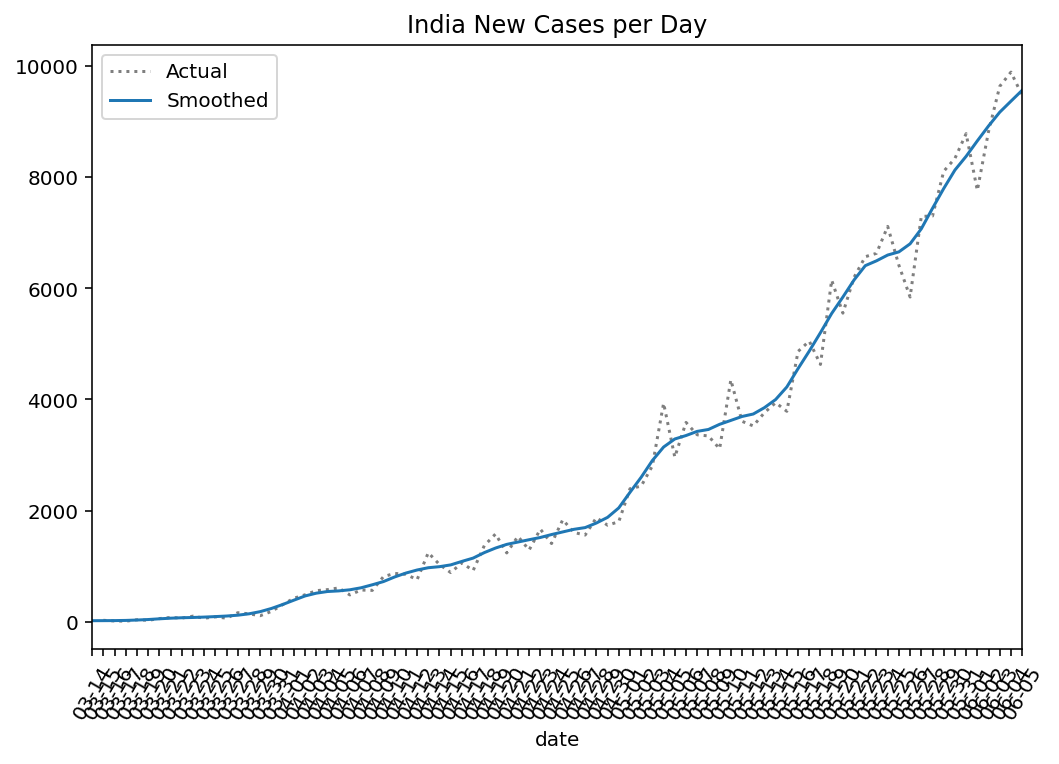

In [18]:
# hide_input
state_name = "India"


def prepare_cases(cases):
    #     print(cases)
    new_cases = cases.diff()
    smoothed = (
        new_cases.rolling(7, win_type="gaussian", min_periods=1, center=True)
        .mean(std=2)
        .round()
    )
    zeros = smoothed.index[smoothed.eq(0)]
    if len(zeros) == 0:
        idx_start = 0
    else:
        last_zero = zeros.max()
        idx_start = smoothed.index.get_loc(last_zero) + 1
    smoothed = smoothed.iloc[idx_start:]
    original = new_cases.loc[smoothed.index]

    return original, smoothed


for k in set(states.index.get_level_values("state")):
    cases = states.xs(k).rename(f"{k} cases")
    original, smoothed = prepare_cases(cases)
    if len(original) == 0 or len(smoothed) == 0:
        FILTERED_REGIONS.append(k)

cases = states.xs(state_name).rename(f"{state_name} cases")
original, smoothed = prepare_cases(cases)

original.plot(
    title=f"{state_name} New Cases per Day",
    c="k",
    linestyle=":",
    alpha=0.5,
    label="Actual",
    legend=True,
    figsize=(600 / 72, 400 / 72),
)

ax = smoothed.plot(label="Smoothed", legend=True)

formatter = mdates.DateFormatter("%m-%d")
ax.xaxis.set_major_formatter(formatter)
locator = mdates.DayLocator()
ax.xaxis.set_major_locator(locator)
plt.xticks(rotation=60)

ax.get_figure().set_facecolor("w")

In [19]:
# hide
def get_posteriors(sr, window=7, min_periods=1):
    lam = sr[:-1].values * np.exp(GAMMA * (r_t_range[:, None] - 1))

    # Note: if you want to have a Uniform prior you can use the following line instead.
    # I chose the gamma distribution because of our prior knowledge of the likely value
    # of R_t.

    prior0 = np.full(len(r_t_range), np.log(1 / len(r_t_range)))
    #     prior0 = np.log(sps.gamma(a=3).pdf(r_t_range) + 1e-14)

    likelihoods = pd.DataFrame(
        # Short-hand way of concatenating the prior and likelihoods
        data=np.c_[prior0, sps.poisson.logpmf(sr[1:].values, lam)],
        index=r_t_range,
        columns=sr.index,
    )

    # Perform a rolling sum of log likelihoods. This is the equivalent
    # of multiplying the original distributions. Exponentiate to move
    # out of log.
    posteriors = likelihoods.rolling(window, axis=1, min_periods=min_periods).sum()
    posteriors = np.exp(posteriors)

    # Normalize to 1.0
    posteriors = posteriors.div(posteriors.sum(axis=0), axis=1)

    return posteriors


posteriors = get_posteriors(smoothed, min_periods=4)
hdis = highest_density_interval(posteriors.dropna(axis=1))
most_likely = posteriors.idxmax().rename("ML")
most_likely

date
2020-03-14     NaN
2020-03-15     NaN
2020-03-16     NaN
2020-03-17    1.31
2020-03-18    1.51
              ... 
2020-06-01    1.15
2020-06-02    1.15
2020-06-03    1.15
2020-06-04    1.13
2020-06-05    1.12
Name: ML, Length: 84, dtype: float64

### The Result

Below you can see every day (row) of the posterior distribution plotted simultaneously. The posteriors start without much confidence (wide) and become progressively more confident (narrower) about the true value of $R_t$

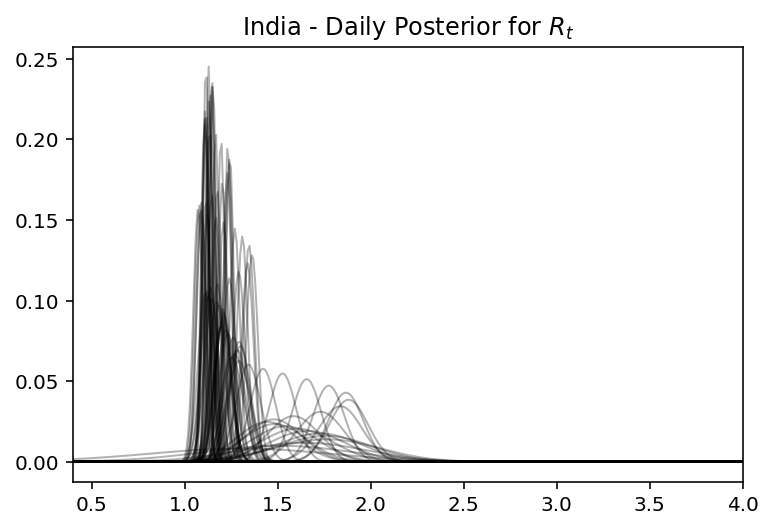

In [20]:
# hide_input
ax.set_xlabel("$R_t$")
ax = posteriors.plot(
    title=f"{state_name} - Daily Posterior for $R_t$",
    legend=False,
    lw=1,
    c="k",
    alpha=0.3,
    xlim=(0.4, 4),
)

### Plotting in the Time Domain with Credible Intervals

Since our results include uncertainty, we'd like to be able to view the most likely value of $R_t$ along with its highest-density interval.

In [21]:
# hide
# Note that this takes a while to execute - it's not the most efficient algorithm
hdis = highest_density_interval(posteriors.dropna(axis=1))

most_likely = posteriors.idxmax().rename("ML")

# Look into why you shift -1
result = pd.concat([most_likely, hdis], axis=1)

result.tail()

,ML,Low,High
date,,,
2020-06-01,1.15,1.11,1.18
2020-06-02,1.15,1.11,1.18
2020-06-03,1.15,1.11,1.18
2020-06-04,1.13,1.09,1.16
2020-06-05,1.12,1.08,1.15


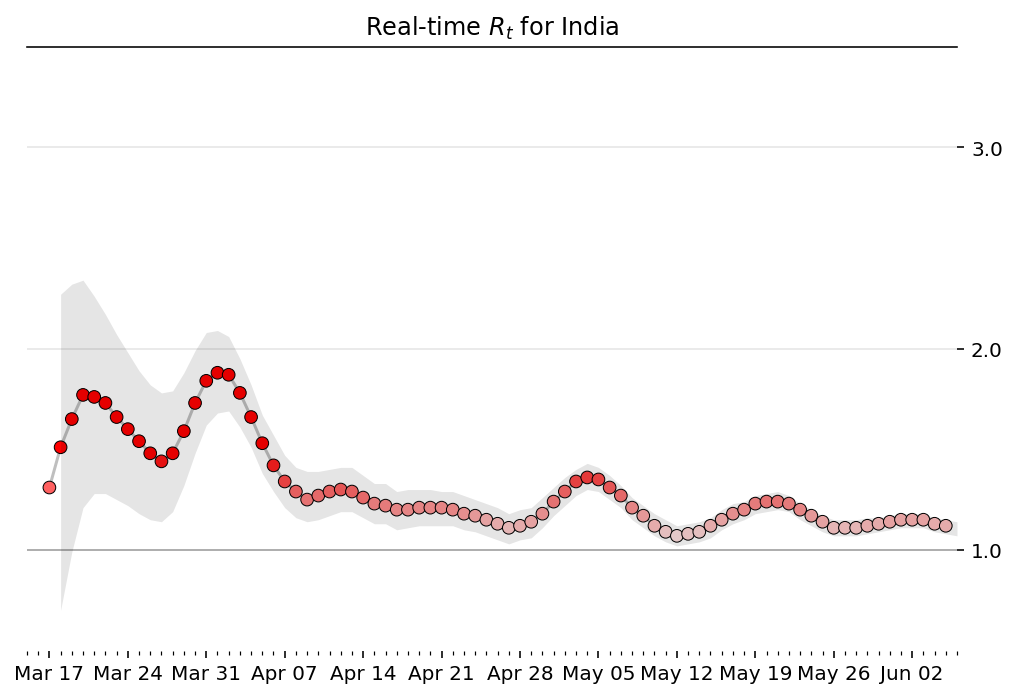

In [22]:
# hide_input
def plot_rt(result, ax, state_name):

    ax.set_title(f"{state_name}")

    # Colors
    ABOVE = [1, 0, 0]
    MIDDLE = [1, 1, 1]
    BELOW = [0, 0, 0]
    cmap = ListedColormap(
        np.r_[np.linspace(BELOW, MIDDLE, 25), np.linspace(MIDDLE, ABOVE, 25)]
    )
    color_mapped = lambda y: np.clip(y, 0.5, 1.5) - 0.5

    index = result["ML"].index.get_level_values("date")
    values = result["ML"].values

    # Plot dots and line
    ax.plot(index, values, c="k", zorder=1, alpha=0.25)
    ax.scatter(
        index,
        values,
        s=40,
        lw=0.5,
        c=cmap(color_mapped(values)),
        edgecolors="k",
        zorder=2,
    )

    # Aesthetically, extrapolate credible interval by 1 day either side
    lowfn = interp1d(
        date2num(index),
        result["Low"].values,
        bounds_error=False,
        fill_value="extrapolate",
    )

    highfn = interp1d(
        date2num(index),
        result["High"].values,
        bounds_error=False,
        fill_value="extrapolate",
    )

    extended = pd.date_range(
        start=pd.Timestamp("2020-03-15"), end=index[-1] + pd.Timedelta(days=1)
    )

    ax.fill_between(
        extended,
        lowfn(date2num(extended)),
        highfn(date2num(extended)),
        color="k",
        alpha=0.1,
        lw=0,
        zorder=3,
    )

    ax.axhline(1.0, c="k", lw=1, label="$R_t=1.0$", alpha=0.25)

    # Formatting
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b"))
    ax.xaxis.set_minor_locator(mdates.DayLocator())

    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))
    ax.yaxis.tick_right()
    ax.spines["left"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.margins(0)
    ax.grid(which="major", axis="y", c="k", alpha=0.1, zorder=-2)
    ax.margins(0)
    ax.set_ylim(0.0, 3.5)
    ax.set_xlim(
        pd.Timestamp("2020-03-15"),
        result.index.get_level_values("date")[-1] + pd.Timedelta(days=1),
    )
    fig.set_facecolor("w")


fig, ax = plt.subplots(figsize=(600 / 72, 400 / 72))

plot_rt(result, ax, state_name)
ax.set_title(f"Real-time $R_t$ for {state_name}")
ax.set_ylim(0.5, 3.5)
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %d"))

In [23]:
# hide
fig.savefig("../images/IndiaRT.png")

### What is the plot saying?

- The red dots represents most likely value of $R_t$. The shaded gray area is the 95% confidence interval and true $R_0$ can be within the grey region.

- When $R_t$ >1, the pandemic will spread exponentially through the entire population. If $R_t$<1, the pandemic will grow to some fixed number less than the population. The lower $R_t$, the more manageable the situation.

### Plotting $R_t$ for selected states

In [24]:
# hide
results = {}
states_to_process = states.loc[
    ~states.index.get_level_values("state").isin(FILTERED_REGIONS)
]
cant_print = []
for state_name, cases in states_to_process.groupby(level="state"):
    clear_output(wait=True)
    print(f"Processing {state_name}")
    new, smoothed = prepare_cases(cases)
    print("\tGetting Posteriors")
    try:
        posteriors = get_posteriors(smoothed)
    except:
        print("hey there")
        display(cases)
    print("\tGetting HDIs")
    hdis = highest_density_interval(posteriors.dropna(axis=1))
    most_likely = posteriors.idxmax().rename("ML")
    if len(most_likely) >= 2:
        result = pd.concat([most_likely, hdis], axis=1)
        results[state_name] = result.droplevel(0)
    else:
        cant_print.append(state_name)

clear_output(wait=True)
print("Done.")
print(cant_print)

Done.
['Sikkim']


### Plot Select States

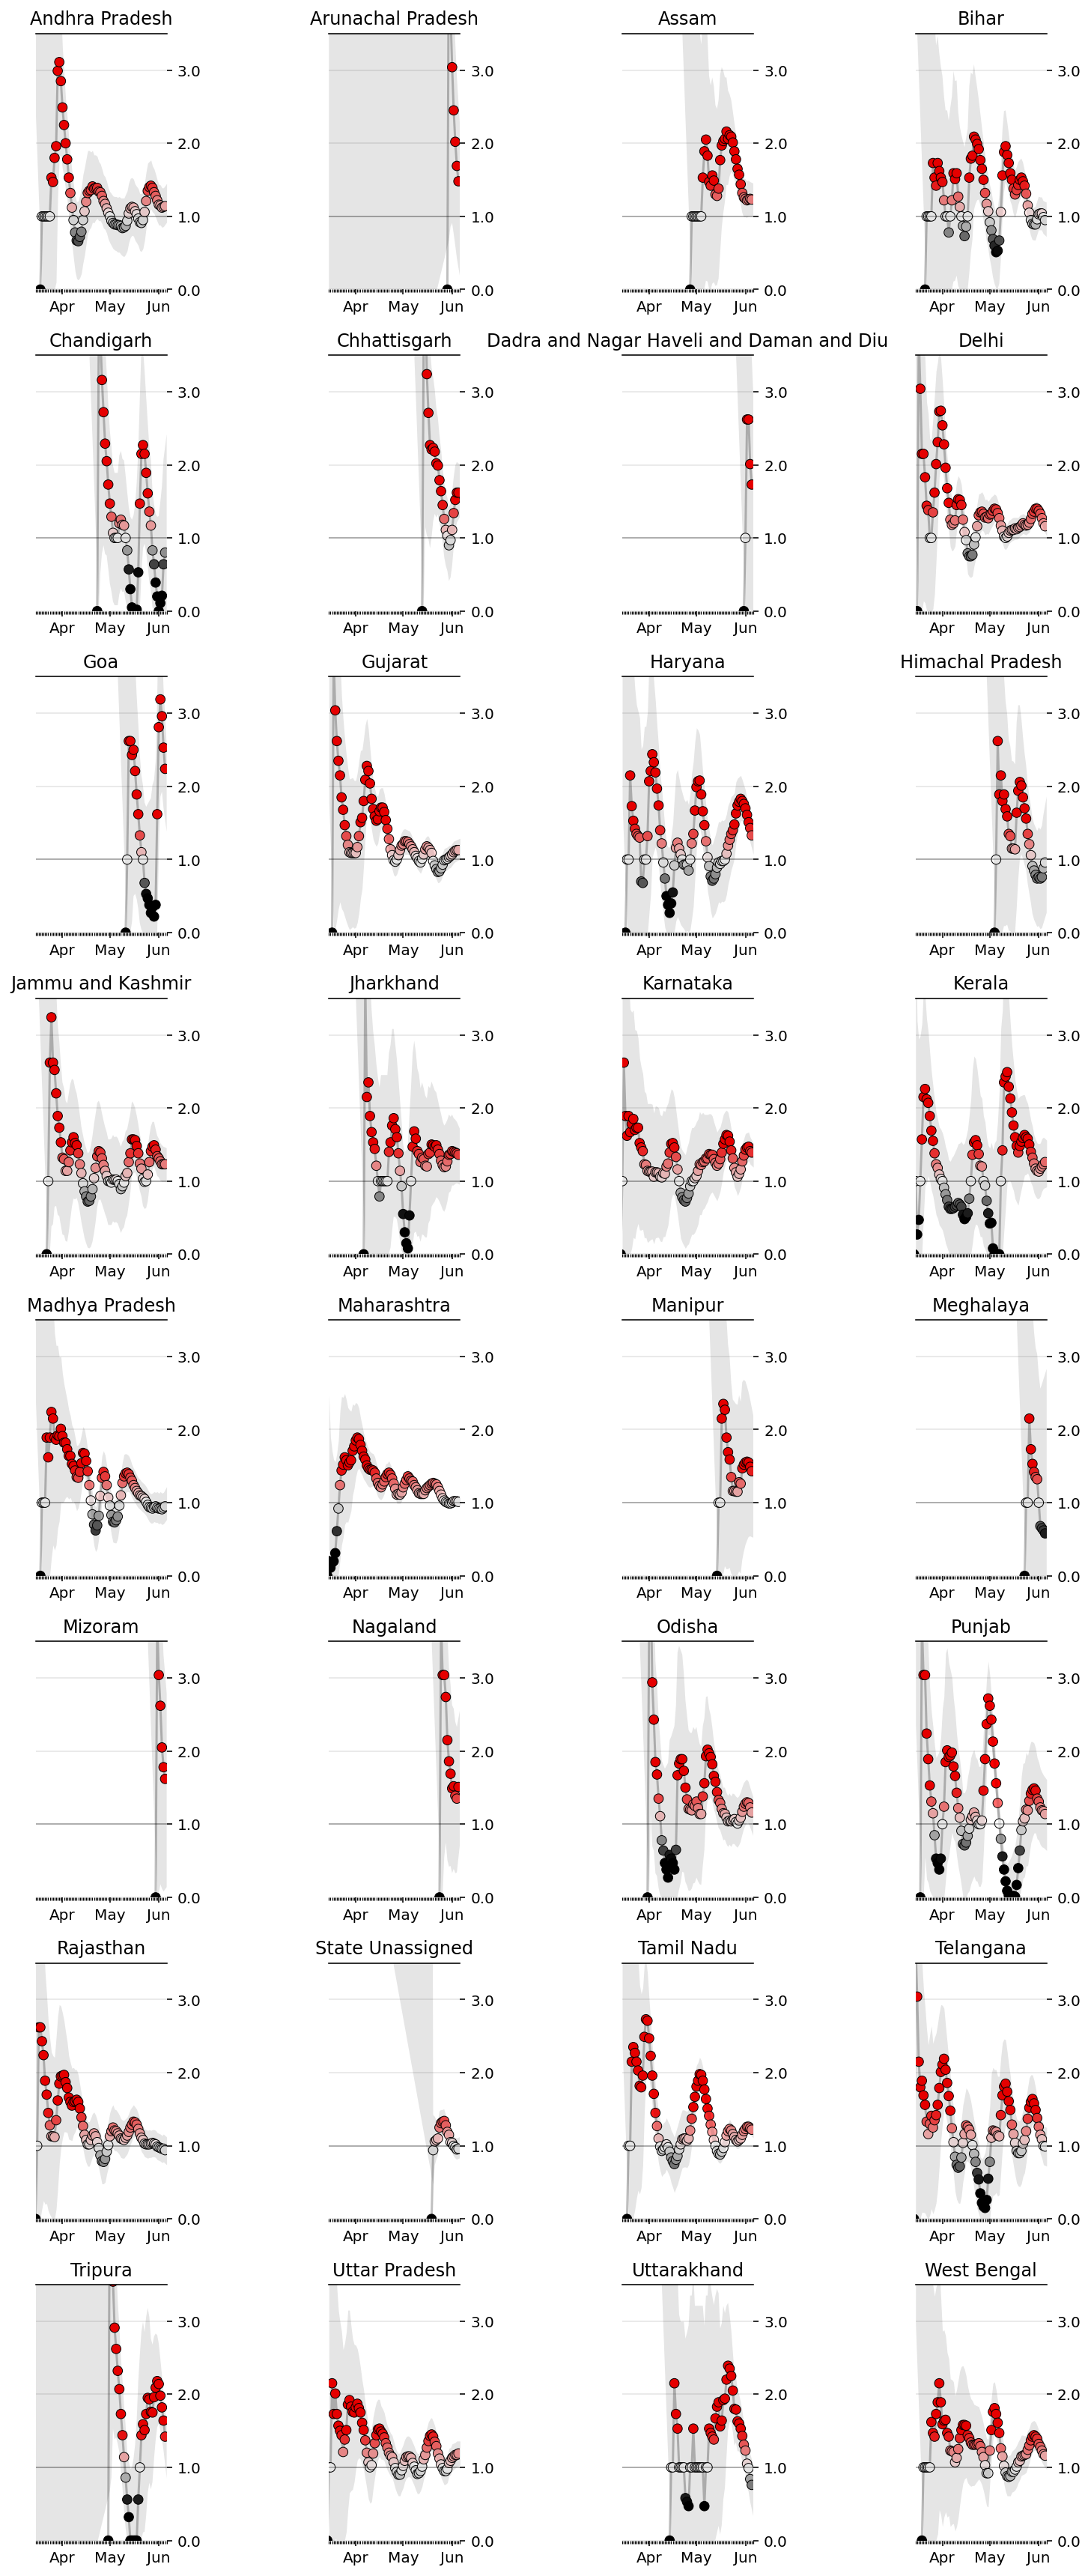

In [25]:
# hide_input
ncols = 4
nrows = int(np.ceil(len(results) / ncols))

# fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows*3))
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, nrows * 3))

for i, (state_name, result) in enumerate(results.items()):
    plot_rt(result, axes.flat[i], state_name)

fig.tight_layout()
fig.set_facecolor("w")
fig.show()

# Data

**Input**: We use APIs from [@amodm](https://api.rootnet.in/) which is turn uses [covid19india.org data](https://api.covid19india.org)

**$R_t$ curve data**:
Find the state wise $R_t$ data here as a csv for easy download: https://github.com/NirantK/CovidSeer/blob/master/_data/rt.csv

In [26]:
# hide
overall = None

for state_name, result in results.items():
    r = result.copy()
    r.index = pd.MultiIndex.from_product([[state_name], result.index])
    if overall is None:
        overall = r
    else:
        overall = pd.concat([overall, r])

overall.sort_index(inplace=True)

In [27]:
# hide
overall.reset_index(inplace=True)
overall.columns = ["State", "Date", "MostLikelyRt", "LowRt", "HighRt"]
filename = "../_data/rt.csv"
overall.to_csv(filename, index=False)

In [28]:
# hide
!head $filename

State,Date,MostLikelyRt,LowRt,HighRt
Andhra Pradesh,2020-03-18,0.0,0.59,12.0
Andhra Pradesh,2020-03-19,1.0,0.0,6.3500000000000005
Andhra Pradesh,2020-03-20,1.0,0.0,5.08
Andhra Pradesh,2020-03-21,1.0,0.0,4.44
Andhra Pradesh,2020-03-22,1.0,0.0,4.03
Andhra Pradesh,2020-03-23,1.0,0.0,3.74
Andhra Pradesh,2020-03-24,1.0,0.0,3.5300000000000002
Andhra Pradesh,2020-03-25,1.53,0.0,3.66
Andhra Pradesh,2020-03-26,1.47,0.0,3.49
